In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential #Initialise our neural network model as a sequential network
from keras.layers import Conv2D #Convolution operation
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers import Activation#Applies activation function
from keras.layers import Dropout#Prevents overfitting by randomly converting few outputs to zero
from keras.layers import MaxPooling2D # Maxpooling function
from keras.layers import Flatten # Converting 2D arrays into a 1D linear vector
from keras.layers import Dense # Regular fully connected neural network
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score


In [0]:
import cv2
from pathlib import Path
import cv2
import dlib
import numpy as np
import argparse
from contextlib import contextmanager
from keras.utils.data_utils import get_file
from google.colab.patches import cv2_imshow


image_dir= '/content/gdrive/My Drive/Colab Notebooks/datasets/facerec'

def yield_images_from_dir(image_dir):
    image_dir = Path(image_dir)

    for image_path in image_dir.glob("*.*"):
        img = cv2.imread(str(image_path), 1)

        if img is not None:
            h, w, _ = img.shape
            r = 640 / max(w, h)
            yield cv2.resize(img, (int(w * r), int(h * r)))


def load_data(dataset_path):
  
  #classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprsie', 'Neutral']  #We will be dealing with seven different types of emotions.

  data = []
  test_data = []
  test_labels = []
  labels =[]

  with open(dataset_path, 'r') as file:
      for line_no, line in enumerate(file.readlines()):
          if 0 < line_no <= 35887:
            curr_class, line, set_type = line.split(',')
            image_data = np.asarray([int(x) for x in line.split()]).reshape(48, 48)#Creating a list out of the string then converting it into a 2-Dimensional numpy array.
            image_data =image_data.astype(np.uint8)/255.0
            
            if (set_type.strip() == 'PrivateTest'):
              
              test_data.append(image_data)
              test_labels.append(curr_class)
            else:
              data.append(image_data)
              labels.append(curr_class)
      
      test_data = np.expand_dims(test_data, -1)
      test_labels = to_categorical(test_labels, num_classes = 7)
      data = np.expand_dims(data, -1)   
      labels = to_categorical(labels, num_classes = 7)
    
      return np.array(data), np.array(labels), np.array(test_data), np.array(test_labels)
    
    
    
    
    


In [0]:
dataset_path = "/content/gdrive/My Drive/Colab Notebooks/fer2013.csv" 
train_data, train_labels, test_data, test_labels = load_data(dataset_path)
#train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = test_size,random_state = seed)

print("Number of images in Training set:", len(train_data))
print("Number of images in Test set:", len(test_data))

Number of images in Training set: 32298
Number of images in Test set: 3589


In [0]:
#######HYPERPARAMATERS###########
epochs = 50
batch_size = 64
learning_rate = 0.001
#################################

model = Sequential()
    
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
adam = optimizers.Adam(lr = learning_rate)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
print(model.summary())

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, mode='auto')
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Model/weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)



model.fit(
          train_data,
          train_labels,
          epochs = epochs,
          batch_size = batch_size,
          validation_split = 0.2,
          shuffle = True,
          callbacks=[lr_reducer, checkpointer, early_stopper]
          )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [0]:
 predicted_test_labels = np.argmax(model.predict(test_data), axis=1)
test_labels = np.argmax(test_labels, axis=1)

In [0]:
from keras.models import model_from_json
model_json = model.to_json()
with open("/content/gdrive/My Drive/Colab Notebooks/datasets/facerec/model.json", "w") as json_file:
    json_file.write(model/_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/My Drive/Colab Notebooks/datasets/facerec/weights.hdf5")

In [0]:
from keras.models import model_from_json
import numpy as np
import cv2

def load_model(path):

	json_file = open(path + 'model.json', 'r')
	loaded_model_json = json_file.read()
	json_file.close()
	
	model = model_from_json(loaded_model_json)
	model.load_weights(path + "weights.hd5")
	print("Loaded model from disk")
	return model
	
def predict_emotion(gray, x, y, w, h):
	face = np.expand_dims(np.expand_dims(np.resize(gray[y:y+w, x:x+h]/255.0, (48, 48)),-1), 0)
	prediction = model.predict([face])

	return(int(np.argmax(prediction)), round(max(prediction[0])*100, 2))
	
path = '/content/gdrive/My Drive/Colab Notebooks/datasets/facerec/'
model = load_model(path)


emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
colour_cycle = ((255, 0, 0), (0, 255, 0), (0, 0, 255), (230, 230, 250))
webcam = cv2.VideoCapture(0)

while True:
	ret, frame = webcam.read()
  
  
  
  
frame1= '/content/gdrive/My Drive/Colab Notebooks/datasets/images.jpeg'
gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

	
faces = faceCascade.detectMultiScale(
			gray,
			scaleFactor=1.1,
			minNeighbors=5,
			minSize=(30, 30)
									)
for (count,(x, y, w, h)) in enumerate(faces):
		colour = colour_cycle[int(count%len(colour_cycle))]
		cv2.rectangle(frame1, (x, y), (x+w, y+h), colour, 2)
		cv2.line(frame1, (x+5, y+h+5),(x+100, y+h+5), colour, 20)
		cv2.putText(frame1, "Face #"+str(count+1), (x+5, y+h+11), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), lineType=cv2.LINE_AA)

		cv2.line(frame1, (x+8, y),(x+150, y), colour, 20)
		emotion_id, confidence = predict_emotion(gray, x, y, w, h)
		emotion = emotion_dict[emotion_id]
		cv2.putText(frame1, emotion + ": " + str(confidence) + "%" , (x+20, y+5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), lineType=cv2.LINE_AA)
	
cv2.imshow('Emotion Recognition - Press q to exit.', frame1)
if cv2.waitKey(1) & 0xFF == ord('q'): break

webcam.release()
cv2.destroyAllWindows()

Loaded model from disk


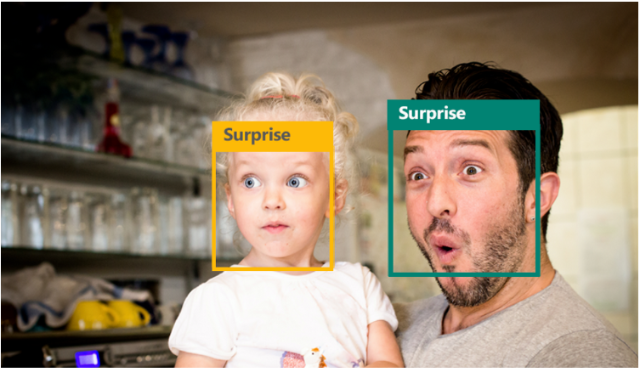

In [0]:
import cv2
from google.colab.patches import cv2_imshow

image_generator = yield_images_from_dir(image_dir) if image_dir else yield_images()

for img in image_generator:
        input_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = np.shape(input_img)
        
        
cv2_imshow(img)





In [0]:
|cd gdrive

SyntaxError: ignored

In [0]:
ls

'My Drive'/


In [0]:
cd My Drive

/content/gdrive/My Drive


In [0]:
ls


'12 April 2019 Sales Report.gsheet'
'12 April 2019 Sales Report.xlsx'
'18TH-20TH FEB.gsheet'
 18youmgest.PNG
'1Trees (1).gdoc'
 1Trees.gdoc
 1Trees.pdf
'220px-Mark_Zuckerberg_em_setembro_de_2014_(cropped).jpg'
 2.gsheet
 2LECTURE_9-DBMS-Ch-8-Normalization
 2.pdf
'3BTrees [Compatibility Mode].pdf'
 3TM.gdoc
 3TM.pdf
 4Lec9-Graphs.pdf
'5 April 2019 Sales Report'
'5 April 2019 Sales Report.gsheet'
 5Lec11-Hashing.pdf
 6Lec7-Heap.pdf
'aakash notes.zip'
'ABHISHEK DELHI REPORT CORRECT (1) (1).gsheet'
'ABHISHEK DELHI REPORT CORRECT (1).gsheet'
'ABHISHEK DELHI REPORT CORRECT (1).xlsx'
'algo file.gdoc'
'alter table employee3005.docx'
 anjali.PNG
'Answer key_ctf.gdoc'
 auric/
 AURIC.gdoc
'AURIC (Responses).gsheet'
 AVL.cpp
'AVL-Trees_latest (1).pptx'
 AVL-Trees_latest.gslides
 AVL-Trees_latest.pptx
'big_oh_theta (1).ppt'
 big_oh_theta.gslides
 big_oh_theta.ppt
 Brochure.gdoc
 C1.gdoc
'cap 1.PNG'
'Cap 2.PNG'
 Cap3.PNG
 Capture4.PNG
 Capture5.PNG
 Capture6.PNG
 Captureavgsal.PNG
 captureeachredboa

In [0]:
cd Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [0]:
cd Model

/content/gdrive/My Drive/Colab Notebooks/Model


In [0]:
ls


weights.hd5


In [0]:
ls -la

total 105782
-rw------- 1 root root 108319768 Apr 15 08:28 weights.hd5


In [0]:
ls -sh

total 104M
104M weights.hd5
